In [1]:
import torch
from torch.utils.data import DataLoader
from Utils.build_dataset import paths_dataset
from torchvision import transforms
from Models.unet_model import UNet
from Utils.FishDataset import FishDataset
from Utils.training import training_loop, predict, iou_np
from scipy import stats
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

In [2]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda:0


In [3]:
label_dict = {0 : "Black Sea Sprat", 1 : "Sea Bass", 2 : "Red Mullet", 3 : "Trout", 4 : "Striped Red Mullet", 
              5 : "Shrimp", 6 : "Red Sea Bream", 7 : "Hourse Mackerel", 8 : "Gilt-Head Bream"}

## Carregando as Imagens

In [4]:
path = 'Dataset/Fish_Dataset/Fish_Dataset/'
df_train_pd, df_valid_pd, df_test_pd = paths_dataset(path)

In [5]:
img_size = 256
classification = True
threshold = 0.5
n_classes = 9
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_size, img_size)), transforms.ToTensor()])

In [6]:
df_train = FishDataset(df_train_pd, transform, transform, classification, img_size)

In [7]:
df_valid = FishDataset(df_valid_pd, transform, transform, classification, img_size)

In [8]:
df_test = FishDataset(df_test_pd, transform, transform, classification, img_size)

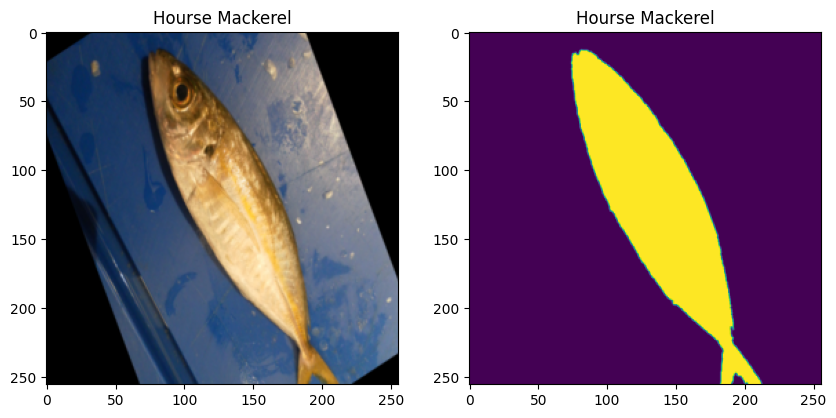

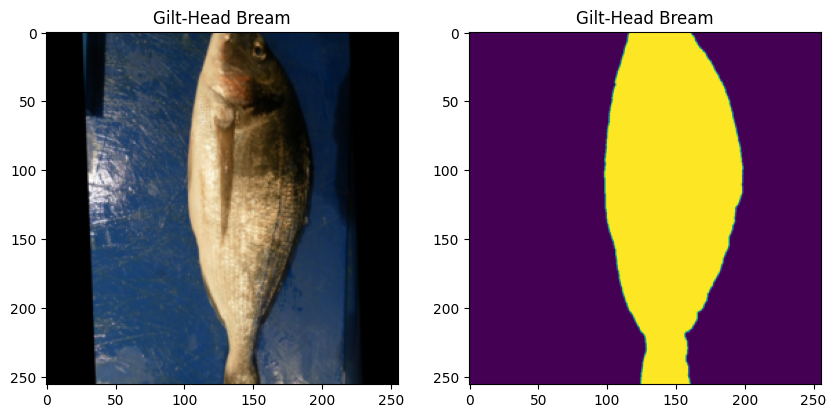

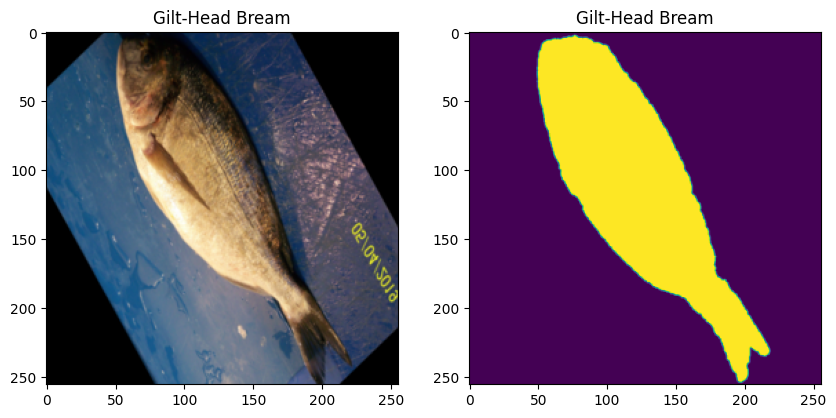

In [9]:
for i in range(3):
    n = random.randint(0, (len(df_train)))
    fig = plt.figure(figsize=(10, 100))
    
    fig.add_subplot(15, 2, 1)
    plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][0].permute(1, 2, 0))
    
    fig.add_subplot(15, 2, 2)
    plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][1][df_train[n][2]])

## Construindo o Modelo

In [15]:
model = UNet(nbClasses = n_classes, outSize = (img_size, img_size))
model.to(device, dtype=dtype)

UNet(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), str

In [16]:
epochs = 30
batch_size = 32
lr = 1e-3
train_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(df_valid, batch_size=batch_size, shuffle=False, num_workers=4)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [17]:
len(train_loader.dataset)

5400

In [18]:
model, optimizer, train_losses, valid_losses, train_iou_list, valid_iou_list = training_loop(epochs, model, train_loader, valid_loader, criterion, optimizer, device, dtype)

Epoch 1 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:32<00:00,  1.83it/s]


Train loss: 0.1169	Valid loss: 0.0653	Train IoU: 0.07	Valid IoU: 0.00
Epoch 2 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:36<00:00,  1.75it/s]


Train loss: 0.0634	Valid loss: 0.0640	Train IoU: 0.00	Valid IoU: 0.00
Epoch 3 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:36<00:00,  1.75it/s]


Train loss: 0.0622	Valid loss: 0.0622	Train IoU: 0.00	Valid IoU: 0.00
Epoch 4 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:35<00:00,  1.76it/s]


Train loss: 0.0603	Valid loss: 0.0607	Train IoU: 0.00	Valid IoU: 0.00
Epoch 5 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:36<00:00,  1.75it/s]


Train loss: 0.0588	Valid loss: 0.0591	Train IoU: 0.00	Valid IoU: 0.01
Epoch 6 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:35<00:00,  1.77it/s]


Train loss: 0.0578	Valid loss: 0.0584	Train IoU: 0.19	Valid IoU: 0.25
Epoch 7 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:36<00:00,  1.76it/s]


Train loss: 0.0559	Valid loss: 0.0552	Train IoU: 1.76	Valid IoU: 3.73
Epoch 8 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:35<00:00,  1.76it/s]


Train loss: 0.0522	Valid loss: 0.0520	Train IoU: 4.05	Valid IoU: 3.42
Epoch 9 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:34<00:00,  1.78it/s]


Train loss: 0.0502	Valid loss: 0.0506	Train IoU: 5.35	Valid IoU: 3.94
Epoch 10 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:35<00:00,  1.77it/s]


Train loss: 0.0491	Valid loss: 0.0482	Train IoU: 5.96	Valid IoU: 8.12
Epoch 11 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:35<00:00,  1.77it/s]


Train loss: 0.0478	Valid loss: 0.0483	Train IoU: 7.02	Valid IoU: 7.46
Epoch 12 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:35<00:00,  1.77it/s]


Train loss: 0.0470	Valid loss: 0.0471	Train IoU: 7.38	Valid IoU: 8.74
Epoch 13 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:31<00:00,  1.84it/s]


Train loss: 0.0458	Valid loss: 0.0455	Train IoU: 8.61	Valid IoU: 10.09
Epoch 14 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:10<00:00,  2.38it/s]


Train loss: 0.0451	Valid loss: 0.0459	Train IoU: 9.42	Valid IoU: 10.06
Epoch 15 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:10<00:00,  2.41it/s]


Train loss: 0.0438	Valid loss: 0.0438	Train IoU: 10.95	Valid IoU: 11.89
Epoch 16 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:10<00:00,  2.41it/s]


Train loss: 0.0423	Valid loss: 0.0415	Train IoU: 14.31	Valid IoU: 14.74
Epoch 17 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:10<00:00,  2.39it/s]


Train loss: 0.0404	Valid loss: 0.0408	Train IoU: 17.46	Valid IoU: 22.80
Epoch 18 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:08<00:00,  2.45it/s]


Train loss: 0.0391	Valid loss: 0.0376	Train IoU: 20.32	Valid IoU: 23.09
Epoch 19 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:06<00:00,  2.53it/s]


Train loss: 0.0377	Valid loss: 0.0373	Train IoU: 22.85	Valid IoU: 28.61
Epoch 20 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.42it/s]


Train loss: 0.0363	Valid loss: 0.0379	Train IoU: 25.64	Valid IoU: 28.07
Epoch 21 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.44it/s]


Train loss: 0.0364	Valid loss: 0.0356	Train IoU: 26.00	Valid IoU: 24.98
Epoch 22 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.42it/s]


Train loss: 0.0355	Valid loss: 0.0345	Train IoU: 27.38	Valid IoU: 31.51
Epoch 23 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:08<00:00,  2.45it/s]


Train loss: 0.0337	Valid loss: 0.0347	Train IoU: 31.08	Valid IoU: 27.16
Epoch 24 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.44it/s]


Train loss: 0.0332	Valid loss: 0.0332	Train IoU: 31.89	Valid IoU: 35.56
Epoch 25 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:10<00:00,  2.39it/s]


Train loss: 0.0323	Valid loss: 0.0321	Train IoU: 33.79	Valid IoU: 37.75
Epoch 26 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.43it/s]


Train loss: 0.0319	Valid loss: 0.0308	Train IoU: 34.59	Valid IoU: 41.02
Epoch 27 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.43it/s]


Train loss: 0.0307	Valid loss: 0.0325	Train IoU: 37.06	Valid IoU: 38.85
Epoch 28 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.44it/s]


Train loss: 0.0300	Valid loss: 0.0308	Train IoU: 38.48	Valid IoU: 37.05
Epoch 29 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.42it/s]


Train loss: 0.0289	Valid loss: 0.0296	Train IoU: 40.54	Valid IoU: 44.69
Epoch 30 out of 30


100%|██████████████████████████████████████████████████| 169/169 [01:09<00:00,  2.44it/s]


Train loss: 0.0285	Valid loss: 0.0278	Train IoU: 41.92	Valid IoU: 42.49


In [19]:
torch.save(model.state_dict(), "unet_classification.pkl")

### Carregando Modelo

In [20]:
model.load_state_dict(torch.load("unet_classification.pkl"))

<All keys matched successfully>

## Avaliando o Modelo

In [21]:
test_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [22]:
model.eval()
model.to(device)

UNet(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), str

In [23]:
img_list_test = list(df_test_pd['image'])
mask_list_test = list(df_test_pd['mask'])
label_list_test = list(df_test_pd['label'])
label_id_list_test = list(df_test_pd['label_id'])

In [24]:
running_iou = 0
running_acc = 0

for i in range(len(img_list_test)):
    label_id = label_id_list_test[i]
    image = cv2.imread(img_list_test[i])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    non_zero = np.nonzero(pred)
    pred_label = stats.mode(non_zero[0]).mode
    iou_pred = iou_np(mask, pred[pred_label])
    running_iou += iou_pred
    if pred_label == label_id:
        running_acc += 1

iou_test = (running_iou / len(img_list_test)) * 100
acc_test = (running_acc / len(img_list_test)) * 100

print(f'Accuracy: {iou_test:.1f}')
print(f'IoU: {acc_test:.1f}')

Accuracy: 56.2
IoU: 90.8


Correct Label: Striped Red Mullet
Predicted Label: Striped Red Mullet
IoU: 27.9


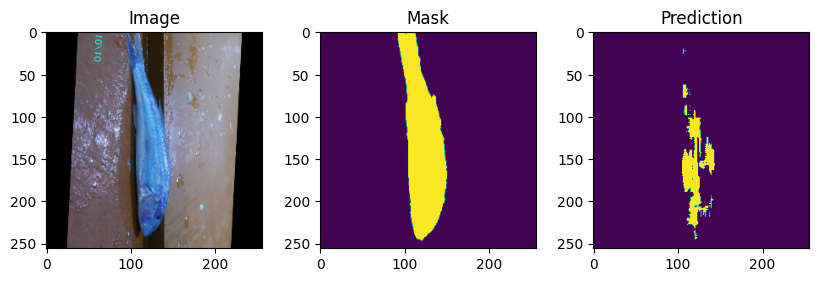

Correct Label: Sea Bass
Predicted Label: Sea Bass
IoU: 52.1


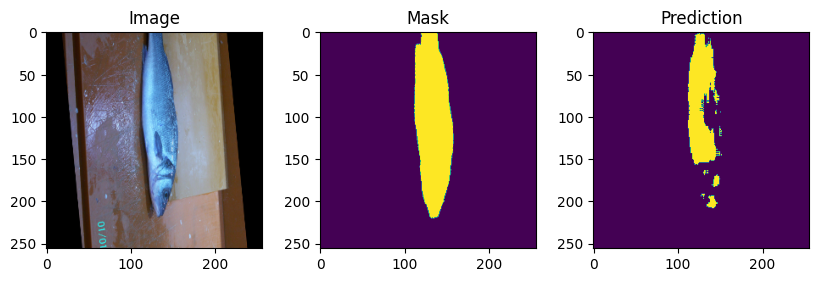

Correct Label: Striped Red Mullet
Predicted Label: Striped Red Mullet
IoU: 49.9


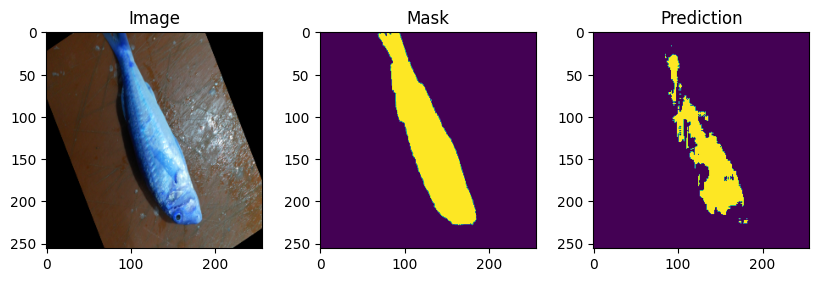

In [25]:
for i in range(3):
    n = random.randint(0, (len(img_list_test)))    
    label = label_list_test[n]
    label_id = label_id_list_test[n]
    image = cv2.imread(img_list_test[n])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[n])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    non_zero = np.nonzero(pred)
    pred_label = stats.mode(non_zero[0]).mode
    iou = iou_np(mask, pred[pred_label]) * 100
    
    print(f'Correct Label: {label}')
    print(f'Predicted Label: {label_dict[pred_label]}')
    print(f'IoU: {iou:.1f}')
    
    fig = plt.figure(figsize=(10, 50))
    
    fig.add_subplot(15, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    
    fig.add_subplot(15, 3, 2)
    plt.title('Mask')
    plt.imshow(mask)
    
    fig.add_subplot(15, 3, 3)
    plt.title('Prediction')
    plt.imshow(pred[pred_label])
    
    plt.show()